In [28]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Effects of scaling on global feature importance in forecasting machine learning models

## Feature scaling
We can use the two types of feature scaling methods to scale the features:
- Linear scaling like min-max, standard scaling, and robust scaling.
- Non-linear scaling like log, power, root, exponential, box-cox, yeo-johnson, and quantile scaling.

These are the formulas for the different types of scaling:
- Linear scaling: $x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$
- Standard scaling: $x' = \frac{x - \text{mean}(x)}{\text{std}(x)}$
- Robust scaling: $x' = \frac{x - \text{median}(x)}{\text{IQR}(x)}$
- Log scaling: $x' = \log(x)$
- Power scaling: $x' = x^p$
- Root scaling: $x' = \sqrt{x}$
- Exponential scaling: $x' = e^x$
- Box-Cox scaling: $x' = \frac{x^p - 1}{p}$
- Yeo-Johnson scaling: $x' = \begin{cases} \left( x + 1 \right)^p & \text{if } x \geq 0 \\ -\left( -x + 1 \right)^p & \text{if } x < 0 \end{cases}$
- Quantile scaling: $x' = \text{CDF}^{-1}(x)$

where $x$ is the original feature, $x'$ is the scaled feature, $\text{min}(x)$ is the minimum value of $x$, $\text{max}(x)$ is the maximum value of $x$, $\text{mean}(x)$ is the mean value of $x$, $\text{std}(x)$ is the standard deviation of $x$, $\text{median}(x)$ is the median value of $x$, $\text{IQR}(x)$ is the interquartile range of $x$, $p$ is the power parameter, and $\text{CDF}^{-1}(x)$ is the inverse cumulative distribution function of $x$.


### Goal
Evaluate the effects of scaling on global feature importance in forecasting machine learning models.


## Datasets:
- Linear dataset: [Ref](data\linear_dep_time_series.csv)
- Non-linear dataset: [Ref](data\nonlinear_time_series.csv)

,date,s_1,s_2,s_3,holiday,weather
0,2023-01-01,50.000000,150.000000,300.000000,0,31.852103
1,2023-01-02,100.000000,200.000000,350.000000,1,13.299608
2,2023-01-03,100.609331,195.258758,368.269784,0,29.497161
3,2023-01-04,99.437613,165.805578,351.979250,0,16.390125
4,2023-01-05,98.066940,176.120203,369.788392,0,16.449677


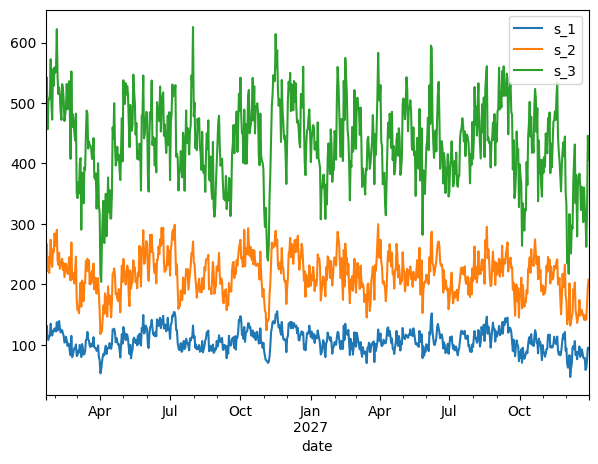

In [15]:
import pandas as pd

df_lin = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df_lin["date"] = pd.to_datetime(df_lin["date"])
df_lin.set_index("date")[series][-710:].plot(figsize=(7, 5))
display(df_lin.head())




,series,date,white_noise,series_seasonal_trend_factor,weekend_trend_factor,holiday_trend_factor,total_factor,value,day_of_year
0,s_3,2019-01-01,0.933390,0.604529,1.0,1.5,1.692784,169.278352,1
1,s_2,2019-01-01,0.946402,0.703397,1.0,1.5,0.998544,99.854437,1
2,s_1,2019-01-01,0.964324,0.802264,1.0,1.5,0.580232,58.023197,1
3,s_3,2019-01-02,0.994360,0.603554,1.0,1.5,1.800451,180.045086,2
4,s_2,2019-01-02,0.903683,0.702666,1.0,1.5,0.952481,95.248114,2


<Axes: xlabel='date'>

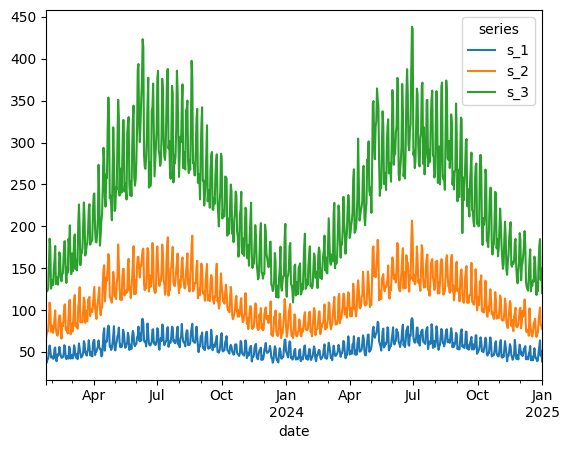

In [65]:
df_nonlin = pd.read_csv("data\\non_linear_time_series.csv", index_col=1)

df_nonlin.reset_index( inplace=True)
df_nonlin["date"] = pd.to_datetime(df_nonlin["date"])
series = ["s_1", "s_2", "s_3"]
display(df_nonlin.head())

df_nonlin.pivot(columns="series", values="value", index="date")[-710:].plot(legend=True)

## Preprocessing of datasets

Preprocesing steps:
- Split the series from the exogenous features.
- Transform to long format 
- Split the data into training and test sets.


C:\Users\Matty\AppData\Local\Temp\ipykernel_42456\991658549.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])
d:\OneDrive - Universitatea Babeş-Bolyai\Research\Forecasting\feature_importance_challenges\tsxp\dataset.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  for idx, (k, v) in enumerate(self.series_dict_train.items()):


Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2027-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=364)


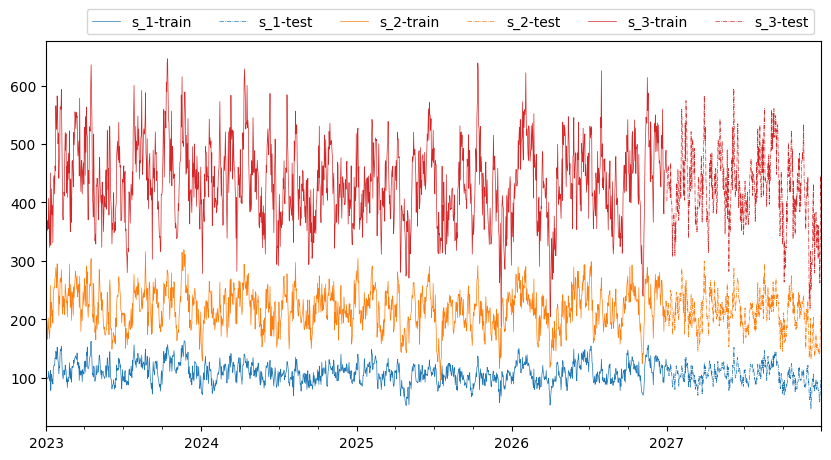

In [111]:
## Prepare linear combined data
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold


df_lin["date"] = pd.to_datetime(df_lin["date"])

# melt the series and prepare for the model
df_demand = df_lin.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df_lin[["date", "holiday", "weather"]].drop_duplicates()


#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
#df_exog["holiday"] = df_exog["holiday"].astype(bool)
df_exog["holiday"] = df_exog["holiday"].astype(int)


df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

# define split date
split_date = "2026-12-31"


lin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
lin_dataset.show_sizes()
lin_dataset.plot_series()

C:\Users\Matty\AppData\Local\Temp\ipykernel_42456\2312244369.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])
C:\Users\Matty\AppData\Local\Temp\ipykernel_42456\2312244369.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])
d:\OneDrive - Universitatea Babeş-Bolyai\Research\Forecasting\feature_importance_challenges\tsxp\dataset.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated i

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  0 non-null      object
 1   weekend_trend_factor  0 non-null      object
 2   holiday_trend_factor  0 non-null      object
 3   day_of_year           0 non-null      object
dtypes: object(4)
memory usage: 124.0+ bytes
Dataset dates      : (Timestamp('2019-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))  (n=2193)
Train dates      : (Timestamp('2019-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))  (n=1826)
Test dates      : (Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))  (n=367)


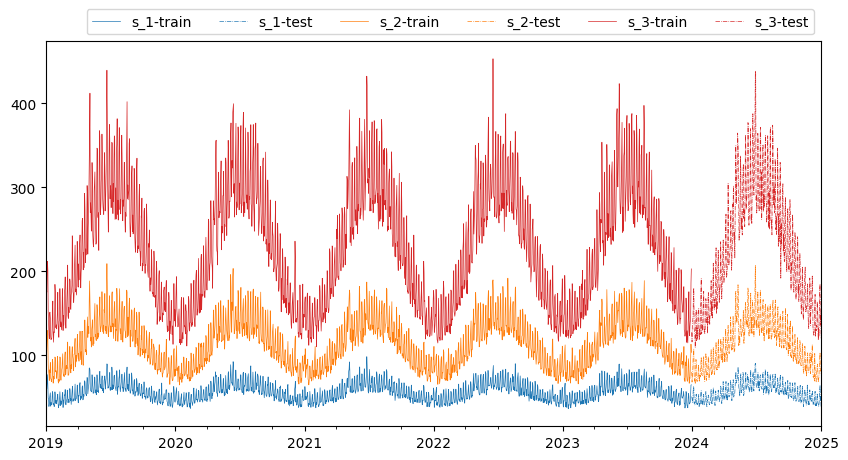

In [113]:
# melt the series and prepare for the model

df_demand = df_nonlin[["date", "series", "value"]].copy()
df_demand["series_id"] = df_demand["series"]
# create exog dataframe for holiday and	weather
df_exog_temp = df_nonlin[
    ["date", "weekend_trend_factor", "holiday_trend_factor", "day_of_year"]
].drop_duplicates()

# replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for s in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = s
    df_exog = pd.concat([df_exog, df_exog_brand])


# replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog.info()
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])

# define split date

split_date = "2023-12-31"
mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

nonlin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
nonlin_dataset.show_sizes()
nonlin_dataset.plot_series()

## Train and explain the models

Train the models:
- LigthGBM model
- Random Forest model ??

Importance metrics:
- SHAP values - Tree explainer, Kernel explainer
- Permutation feature importance - Mean average error (MAE) 

With and without scaling the features.

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.507296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.500902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training 

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.407917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 252.400897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start train

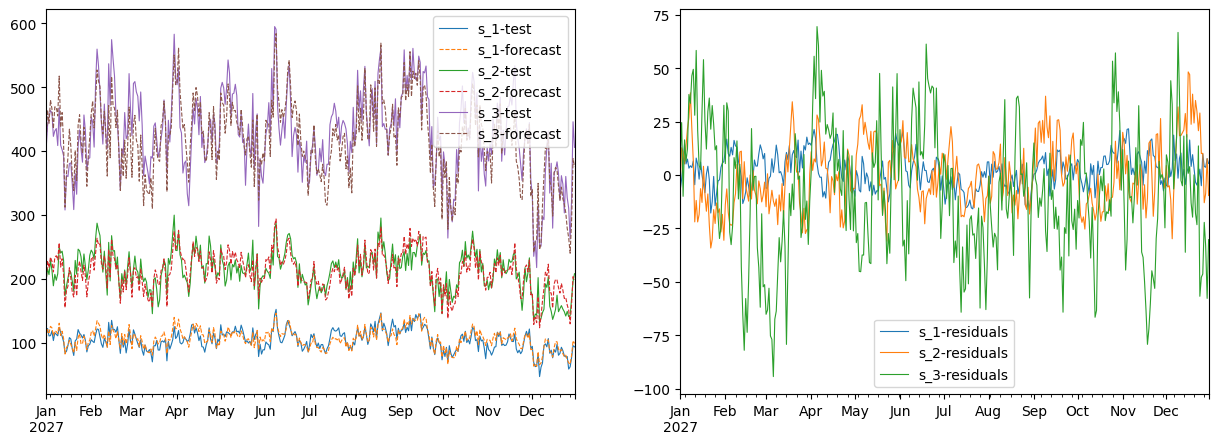

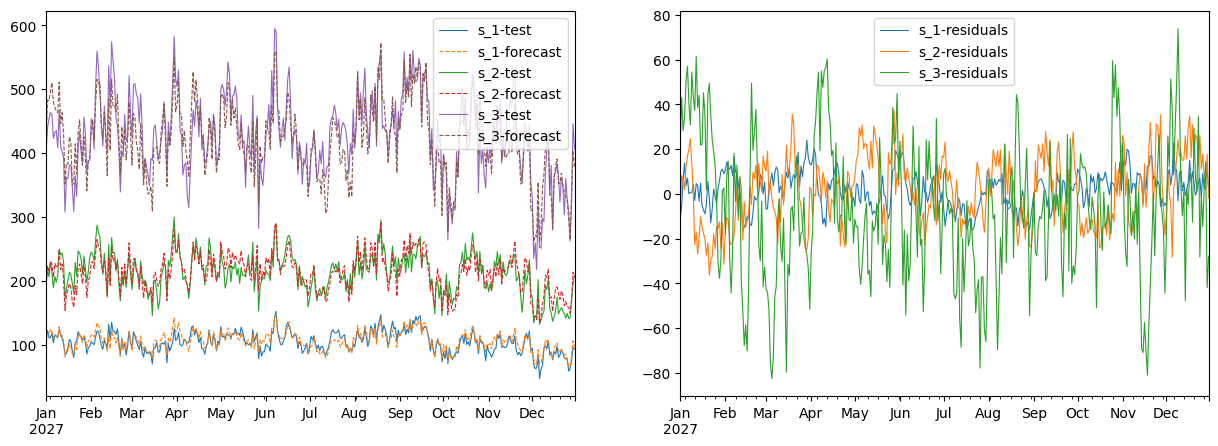

In [127]:
# forecast linear
# 
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
forecaster_scaled.plot_forecast()


regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=None
    # search_space=search_space,
)
t2 = forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
forecaster_nonscaled.plot_forecast()



In [128]:
from tsxp.forecaster import ForecasterMsExog

from sklearn.ensemble import RandomForestRegressor

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }


regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
forecaster_scaled.plot_forecast()


regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=None
    # search_space=search_space,
)
t2 = forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
forecaster_nonscaled.plot_forecast()


  0%|          | 0/10 [00:00<?, ?it/s]

[W 2024-12-14 17:44:29,256] Trial 0 failed with parameters: {'lags': 4, 'n_estimators': 349} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\model_selection\_search.py", line 1839, in _objective
    metrics, _ = backtesting_forecaster_multiseries(
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\model_selection\_validation.py", line 905, in backtesting_forecaster_multiseries
    metrics_levels, backtest_predictions = _backtesting_forecaster_multiseries(
  File "c:\Users\Matty\anaconda3\envs\feature_importance\lib\site-packages\skforecast\model_selection\_validation.py", line 728, in _backtesting_forecaster_multiseries
    backtest_predictions = Parallel(n_jobs=n_jobs)

KeyboardInterrupt: 